PERFORMING MODEL ANALYSIS WITH OUTLIERS REMOVED TRAIN AND TEST DATASET

In [10]:
import pandas as pd
dftrain =pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\outliers_removed.csv')
dftrain.head(3)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,CountryCode,State,City,Year,Month,Day,Hour,Minute,Second,Weekday
0,180388628218,0,612,123247,2024-06-04 06:05:15+00:00,7,6,InitialAccess,TruePositive,Ip,...,31,6,3,2024,6,4,6,5,15,1
1,455266534868,88,326,210035,2024-06-14 03:01:25+00:00,58,43,Exfiltration,FalsePositive,User,...,242,1445,10630,2024,6,14,3,1,25,4
2,214748368522,148,4359,188041,2024-06-15 01:08:07+00:00,9,74,Execution,TruePositive,User,...,242,1445,10630,2024,6,15,1,8,7,5


In [11]:
dftrain=dftrain.drop('Timestamp',axis=1)

In [12]:
dftrain=dftrain.drop_duplicates()

In [13]:
dftrain.shape

(4714562, 41)

In [14]:
dftrain.to_csv('finaldftrain.csv', index=False)

FEATURE IMPORTANCE WITH RANDAM FOREST
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

dftrain_sample = dftrain.sample(n=1000000, random_state=42)  # Sample 1 million rows

# Step 1: Apply Label Encoding directly to all features except 'IncidentGrade'
label_encoder = LabelEncoder()

for col in dftrain_sample.columns:
    if col != 'IncidentGrade':  # Exclude target variable from label encoding
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# Step 2: Split features and target
X_sample = dftrain_sample.drop(columns=['IncidentGrade'])
y_sample = dftrain_sample['IncidentGrade']

# Step 3: Apply Standard Scaling only to the features
scaler = StandardScaler()
X_scaled_sample = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns)

# Step 4: Train a Random Forest model to get feature importance
model = RandomForestClassifier()
model.fit(X_scaled_sample, y_sample)

# Step 5: Get feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_sample.columns, 'Importance': importances})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top features
print(feature_importance.head(15))


        Feature  Importance
1         OrgId    0.255952
4    DetectorId    0.115361
5    AlertTitle    0.090709
3       AlertId    0.070330
6      Category    0.058196
2    IncidentId    0.056500
0            Id    0.042056
35          Day    0.034772
7    EntityType    0.031869
36         Hour    0.024470
38       Second    0.024027
37       Minute    0.023908
39      Weekday    0.021006
14   AccountUpn    0.015513
30  CountryCode    0.012345

LOGISTIC REGRESSION WITH SAMPLE TRAIN DATASET 

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 0: Sample 100,000 Rows
# -------------------------------


dftrain_sample = dftrain.sample(n=10000, random_state=42)  # Sample 100,000 rows
dftrain_sample.reset_index(drop=True, inplace=True)

# -------------------------------
# Step 1: Label Encoding
# -------------------------------

label_encoder = LabelEncoder()

# Iterate through each column except the target
for col in dftrain_sample.columns:
    if col != 'IncidentGrade':
        # Convert to string to handle any non-numeric data
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# -------------------------------
# Step 2: Split Features and Target
# -------------------------------

X = dftrain_sample.drop(columns=['IncidentGrade'])
y = dftrain_sample['IncidentGrade']

# -------------------------------
# Step 3: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 4: Select Top Features
# -------------------------------

# List of important features based on prior Random Forest analysis
important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode'
]

# Select only the important features
X_top = X_scaled[important_features]

# -------------------------------
# Step 5: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_top, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 6: Handle Class Imbalance with SMOTETomek
# -------------------------------

# Initialize SMOTETomek to combine oversampling and cleaning
smote_tomek = SMOTETomek(random_state=42)

# Apply SMOTETomek to the training data
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

print("\nAfter SMOTETomek, class distribution in the training set:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------
# Step 7: Define Logistic Regression Model and Hyperparameter Grid
# -------------------------------

logreg = LogisticRegression(solver='liblinear', random_state=42)

# Define hyperparameter grid for RandomizedSearch
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'penalty': ['l1', 'l2']  # L1 = Lasso, L2 = Ridge
}

# -------------------------------
# Step 8: Hyperparameter Tuning with RandomizedSearchCV
# -------------------------------

random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=20,  # Reduce number of iterations
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
print("\nStarting hyperparameter tuning...")
random_search.fit(X_train_res, y_train_res)

# Best parameters
print("\nBest Hyperparameters:")
print(random_search.best_params_)

# Best estimator
best_logreg = random_search.best_estimator_

# -------------------------------
# Step 9: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred = best_logreg.predict(X_val)

# Calculate performance metrics
f1 = f1_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
precision = precision_score(y_val, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"\nF1 Score (Weighted): {f1:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# -------------------------------
# Step 10: Optional - Cross-Validation Scores
# -------------------------------

# Perform cross-validation on the entire training set
print("\nPerforming cross-validation on the best Logistic Regression model...")

cv_f1 = cross_val_score(best_logreg, X_train_res, y_train_res, cv=5, scoring='f1_weighted', n_jobs=-1)
cv_recall = cross_val_score(best_logreg, X_train_res, y_train_res, cv=5, scoring='recall_weighted', n_jobs=-1)
cv_precision = cross_val_score(best_logreg, X_train_res, y_train_res, cv=5, scoring='precision_weighted', n_jobs=-1)

print(f"\nCross-Validation F1 Scores: {cv_f1}")
print(f"Mean CV F1 Score: {cv_f1.mean():.4f}")
print(f"Cross-Validation Recall Scores: {cv_recall}")
print(f"Mean CV Recall Score: {cv_recall.mean():.4f}")
print(f"Cross-Validation Precision Scores: {cv_precision}")
print(f"Mean CV Precision Score: {cv_precision.mean():.4f}")


Training Set Size: 7000 samples
Validation Set Size: 3000 samples

After SMOTETomek, class distribution in the training set:
IncidentGrade
FalsePositive     3652
BenignPositive    3601
TruePositive      3587
Name: count, dtype: int64

Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters:
{'penalty': 'l2', 'C': np.float64(0.004832930238571752)}

F1 Score (Weighted): 0.5529
Recall (Weighted): 0.5407
Precision (Weighted): 0.5765

Confusion Matrix:
[[375 243 202]
 [185 287 132]
 [314 302 960]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.43      0.46      0.44       820
 FalsePositive       0.34      0.48      0.40       604
  TruePositive       0.74      0.61      0.67      1576

      accuracy                           0.54      3000
     macro avg       0.51      0.51      0.50      3000
  weighted avg       0.58      0.54      0.55      3000


Performing cross-val

RF MODEL WITH BEST FEATURE AND SMOTE

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 0: Sample 100,000 Rows
# -------------------------------


dftrain_sample = dftrain.sample(n=20000, random_state=42)  # Sample 100,000 rows
dftrain_sample.reset_index(drop=True, inplace=True)

# -------------------------------
# Step 1: Label Encoding
# -------------------------------

label_encoder = LabelEncoder()

# Iterate through each column except the target
for col in dftrain_sample.columns:
    if col != 'IncidentGrade':
        # Convert to string to handle any non-numeric data
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# -------------------------------
# Step 2: Split Features and Target
# -------------------------------

X = dftrain_sample.drop(columns=['IncidentGrade'])
y = dftrain_sample['IncidentGrade']

# -------------------------------
# Step 3: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 4: Select Top Features
# -------------------------------

# List of important features based on prior Random Forest analysis
important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode'
]

# Select only the important features
X_top = X_scaled[important_features]

# -------------------------------
# Step 5: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_top, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 6: Handle Class Imbalance with SMOTE
# -------------------------------

# Initialize SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE, class distribution in the training set:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------
# Step 7: Define Random Forest Model and Hyperparameter Grid
# -------------------------------

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define hyperparameter grid for RandomizedSearch
param_dist_rf = {
    'n_estimators': np.arange(50, 300, 50),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples to be at a leaf node
}

# -------------------------------
# Step 8: Hyperparameter Tuning with RandomizedSearchCV
# -------------------------------

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,  # Reduce number of iterations
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
print("\nStarting hyperparameter tuning for Random Forest...")
random_search_rf.fit(X_train_res, y_train_res)

# Best parameters
print("\nBest Hyperparameters for Random Forest:")
print(random_search_rf.best_params_)

# Best estimator
best_rf = random_search_rf.best_estimator_

# -------------------------------
# Step 9: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_rf = best_rf.predict(X_val)

# Calculate performance metrics
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

print(f"\nF1 Score (Weighted): {f1_rf:.4f}")
print(f"Recall (Weighted): {recall_rf:.4f}")
print(f"Precision (Weighted): {precision_rf:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

# -------------------------------
# Step 10: Optional - Cross-Validation Scores
# -------------------------------

# Perform cross-validation on the entire training set
print("\nPerforming cross-validation on the best Random Forest model...")

cv_f1_rf = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring='f1_weighted', n_jobs=-1)
cv_recall_rf = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring='recall_weighted', n_jobs=-1)
cv_precision_rf = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring='precision_weighted', n_jobs=-1)

print(f"\nCross-Validation F1 Scores: {cv_f1_rf}")
print(f"Mean CV F1 Score: {cv_f1_rf.mean():.4f}")
print(f"Cross-Validation Recall Scores: {cv_recall_rf}")
print(f"Mean CV Recall Score: {cv_recall_rf.mean():.4f}")
print(f"Cross-Validation Precision Scores: {cv_precision_rf}")
print(f"Mean CV Precision Score: {cv_precision_rf.mean():.4f}")


Training Set Size: 14000 samples
Validation Set Size: 6000 samples

After SMOTE, class distribution in the training set:
IncidentGrade
TruePositive      7342
BenignPositive    7342
FalsePositive     7342
Name: count, dtype: int64

Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters for Random Forest:
{'n_estimators': np.int64(150), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}

F1 Score (Weighted): 0.8644
Recall (Weighted): 0.8632
Precision (Weighted): 0.8720

Confusion Matrix:
[[1507   62   78]
 [ 185  925   96]
 [ 301   99 2747]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.76      0.91      0.83      1647
 FalsePositive       0.85      0.77      0.81      1206
  TruePositive       0.94      0.87      0.91      3147

      accuracy                           0.86      6000
     macro avg       0.85      0.85      0.85      600

XGB MODEL WITH BEST FEATURE AND SMOTE

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 0: Sample 100,000 Rows
# -------------------------------


dftrain_sample = dftrain.sample(n=100_000, random_state=42)  # Sample 100,000 rows
dftrain_sample.reset_index(drop=True, inplace=True)

# -------------------------------
# Step 1: Label Encoding
# -------------------------------

label_encoder = LabelEncoder()

# Encode the target variable as well as the features
dftrain_sample['IncidentGrade'] = label_encoder.fit_transform(dftrain_sample['IncidentGrade'])

# Iterate through each column except the target
for col in dftrain_sample.columns:
    if col != 'IncidentGrade':
        # Convert to string to handle any non-numeric data
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# -------------------------------
# Step 2: Split Features and Target
# -------------------------------

X = dftrain_sample.drop(columns=['IncidentGrade'])
y = dftrain_sample['IncidentGrade']

# -------------------------------
# Step 3: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 4: Select Top Features
# -------------------------------

# List of important features based on prior Random Forest analysis
important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode'
]

# Select only the important features
X_top = X_scaled[important_features]

# -------------------------------
# Step 5: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_top, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 6: Handle Class Imbalance with SMOTE
# -------------------------------

# Initialize SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE, class distribution in the training set:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------
# Step 7: Define XGBoost Model and Hyperparameter Grid
# -------------------------------

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define hyperparameter grid for RandomizedSearch
param_dist_xgb = {
    'n_estimators': np.arange(50, 300, 50),  # Number of trees
    'max_depth': [3, 6, 9],  # Maximum depth of trees
    'learning_rate': np.logspace(-3, 0, 5),  # Learning rate
    'subsample': [0.7, 0.8, 1.0],  # Subsampling ratio
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used in each tree
}

# -------------------------------
# Step 8: Hyperparameter Tuning with RandomizedSearchCV
# -------------------------------

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,  # Reduce number of iterations
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
print("\nStarting hyperparameter tuning for XGBoost...")
random_search_xgb.fit(X_train_res, y_train_res)

# Best parameters
print("\nBest Hyperparameters for XGBoost:")
print(random_search_xgb.best_params_)

# Best estimator
best_xgb = random_search_xgb.best_estimator_

# -------------------------------
# Step 9: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_xgb = best_xgb.predict(X_val)

# Calculate performance metrics
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

print(f"\nF1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

# -------------------------------
# Step 10: Optional - Cross-Validation Scores
# -------------------------------

# Perform cross-validation on the entire training set
print("\nPerforming cross-validation on the best XGBoost model...")

cv_f1_xgb = cross_val_score(best_xgb, X_train_res, y_train_res, cv=5, scoring='f1_weighted', n_jobs=-1)
cv_recall_xgb = cross_val_score(best_xgb, X_train_res, y_train_res, cv=5, scoring='recall_weighted', n_jobs=-1)
cv_precision_xgb = cross_val_score(best_xgb, X_train_res, y_train_res, cv=5, scoring='precision_weighted', n_jobs=-1)

print(f"\nCross-Validation F1 Scores: {cv_f1_xgb}")
print(f"Mean CV F1 Score: {cv_f1_xgb.mean():.4f}")
print(f"Cross-Validation Recall Scores: {cv_recall_xgb}")
print(f"Mean CV Recall Score: {cv_recall_xgb.mean():.4f}")
print(f"Cross-Validation Precision Scores: {cv_precision_xgb}")
print(f"Mean CV Precision Score: {cv_precision_xgb.mean():.4f}")


Training Set Size: 70000 samples
Validation Set Size: 30000 samples

After SMOTE, class distribution in the training set:
IncidentGrade
2    36793
1    36793
0    36793
Name: count, dtype: int64

Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters for XGBoost:
{'subsample': 0.8, 'n_estimators': np.int64(250), 'max_depth': 9, 'learning_rate': np.float64(1.0), 'colsample_bytree': 1.0}

F1 Score (Weighted): 0.9282
Recall (Weighted): 0.9281
Precision (Weighted): 0.9287

Confusion Matrix:
[[ 7634   325   304]
 [  445  5243   280]
 [  558   246 14965]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8263
           1       0.90      0.88      0.89      5968
           2       0.96      0.95      0.96     15769

    accuracy                           0.93     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       

ANALYSIS WITH PCA AND SMOTE

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load a Sample from Full Dataset (100,000 rows)
# -------------------------------


dftrain_sample = dftrain.sample(n=100000, random_state=42)

# -------------------------------
# Step 2: Label Encoding
# -------------------------------

label_encoder = LabelEncoder()

# Encode the target variable 'IncidentGrade' and other categorical features
dftrain_sample['IncidentGrade'] = label_encoder.fit_transform(dftrain_sample['IncidentGrade'])

# Iterate through each column except the target
for col in dftrain_sample.columns:
    if col != 'IncidentGrade':
        # Convert to string to handle any non-numeric data
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# -------------------------------
# Step 3: Split Features and Target
# -------------------------------

X = dftrain_sample.drop(columns=['IncidentGrade'])
y = dftrain_sample['IncidentGrade']

# -------------------------------
# Step 4: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 5: Apply PCA for Dimensionality Reduction
# -------------------------------

# Initialize PCA to retain 95% of the explained variance
pca = PCA(n_components=0.95)

# Apply PCA to the scaled data
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# -------------------------------
# Step 6: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 7: Handle Class Imbalance with SMOTE
# -------------------------------

# Initialize SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE, class distribution in the training set:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------
# Step 8: Define XGBoost Model with Best Hyperparameters
# -------------------------------

# Best hyperparameters provided
best_params = {
    'subsample': 0.8,
    'n_estimators': 250,
    'max_depth': 9,
    'learning_rate': 1.0,
    'colsample_bytree': 1.0
}

# Initialize XGBoost model with best parameters
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', **best_params)

# -------------------------------
# Step 9: Hyperparameter Tuning and Cross-Validation Combined
# -------------------------------

# Perform cross-validation with hyperparameter tuning in one step (reducing computation time)
print("\nStarting hyperparameter tuning for XGBoost...")

# Fit the model on the resampled training data
xgb.fit(X_train_res, y_train_res)

# -------------------------------
# Step 10: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_xgb = xgb.predict(X_val)

# Calculate performance metrics
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))


Original number of features: 40
Reduced number of features after PCA: 19
Training Set Size: 70000 samples
Validation Set Size: 30000 samples

After SMOTE, class distribution in the training set:
IncidentGrade
2    36793
1    36793
0    36793
Name: count, dtype: int64

Starting hyperparameter tuning for XGBoost...

Accuracy: 0.8101
F1 Score (Weighted): 0.8106
Recall (Weighted): 0.8101
Precision (Weighted): 0.8122

Confusion Matrix:
[[ 6615   667   981]
 [  835  4237   896]
 [ 1508   810 13451]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      8263
           1       0.74      0.71      0.73      5968
           2       0.88      0.85      0.87     15769

    accuracy                           0.81     30000
   macro avg       0.79      0.79      0.79     30000
weighted avg       0.81      0.81      0.81     30000



ANALYSIS WITHOUT PCA AND SMOTE INSTEAD BEST FEATURES AND CLASS WEIGHTS

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Sample 200,000 Rows from dftrain
# -------------------------------


dftrain_sample = dftrain.sample(n=200_00, random_state=42).reset_index(drop=True)

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain_sample = dftrain_sample[important_features]

# -------------------------------
# Step 3: Label Encoding All Features
# -------------------------------

label_encoder = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain_sample['IncidentGrade'] = label_encoder.fit_transform(dftrain_sample['IncidentGrade'])

# Encode all features
for col in dftrain_sample.columns:
    if col != 'IncidentGrade':
        dftrain_sample[col] = label_encoder.fit_transform(dftrain_sample[col].astype(str))

# -------------------------------
# Step 4: Split Features and Target
# -------------------------------

X = dftrain_sample.drop(columns=['IncidentGrade'])
y = dftrain_sample['IncidentGrade']

# -------------------------------
# Step 5: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 6: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

# -------------------------------
# Step 8: Define XGBoost Model and Hyperparameter Grid
# -------------------------------

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=class_weight_dict
)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

# -------------------------------
# Step 9: Hyperparameter Tuning with GridSearchCV
# -------------------------------

# Use Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nStarting hyperparameter tuning for XGBoost...")
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters for XGBoost:")
print(best_params)

# Best estimator
best_xgb = grid_search.best_estimator_

# -------------------------------
# Step 10: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_xgb = best_xgb.predict(X_val)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))


Training Set Size: 14000 samples
Validation Set Size: 6000 samples

Class Weights:
{np.int64(0): np.float64(1.214329083181542), np.int64(1): np.float64(1.6577856719952635), np.int64(2): np.float64(0.6356124580041769)}

Starting hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 128 candidates, totalling 384 fits

Best Hyperparameters for XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1.0}

Accuracy: 0.9068
F1 Score (Weighted): 0.9068
Recall (Weighted): 0.9068
Precision (Weighted): 0.9095

Confusion Matrix:
[[1519   38   90]
 [ 129  978   99]
 [ 167   36 2944]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1647
           1       0.93      0.81      0.87      1206
           2       0.94      0.94      0.94      3147

    accuracy                           0.91      6000
   macro avg       0.90     

XGB MODEL ON FULL DATASET WITH BEST PARAMETERS,CLASS WEIGHT

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Full Dataset
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\cleandftrain.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]

# -------------------------------
# Step 3: Label Encode All Features
# -------------------------------

label_encoder = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder.fit_transform(dftrain['IncidentGrade'])

# Encode all features
for col in dftrain.columns:
    if col != 'IncidentGrade':
        dftrain[col] = label_encoder.fit_transform(dftrain[col].astype(str))

# -------------------------------
# Step 4: Split Features and Target
# -------------------------------

X = dftrain.drop(columns=['IncidentGrade'])
y = dftrain['IncidentGrade']

# -------------------------------
# Step 5: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 6: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

# Compute sample weights for training data
sample_weights = y_train.map(class_weight_dict)

# -------------------------------
# Step 8: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 9: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the full dataset...")
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# -------------------------------
# Step 10: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_xgb = xgb.predict(X_val)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))


Training Set Size: 3300193 samples
Validation Set Size: 1414369 samples

Class Weights:
{np.int64(0): np.float64(1.211949045297068), np.int64(1): np.float64(1.676362587197504), np.int64(2): np.float64(0.6335717727645344)}

Training the XGBoost model on the full dataset...

Accuracy: 0.9645
F1 Score (Weighted): 0.9647
Recall (Weighted): 0.9645
Precision (Weighted): 0.9653

Confusion Matrix:
[[377064   7702   4241]
 [  7063 271546   2629]
 [ 18662   9904 715558]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    389007
           1       0.94      0.97      0.95    281238
           2       0.99      0.96      0.98    744124

    accuracy                           0.96   1414369
   macro avg       0.96      0.97      0.96   1414369
weighted avg       0.97      0.96      0.96   1414369



good predicted values for xgb with full train dataset

Training Set Size: 3300193 samples
Validation Set Size: 1414369 samples

Class Weights:
{np.int64(0): np.float64(1.211949045297068), np.int64(1): np.float64(1.676362587197504), np.int64(2): np.float64(0.6335717727645344)}

Training the XGBoost model on the full dataset...

Accuracy: 0.9645
F1 Score (Weighted): 0.9647
Recall (Weighted): 0.9645
Precision (Weighted): 0.9653

Confusion Matrix:
[[377064   7702   4241]
 [  7063 271546   2629]
 [ 18662   9904 715558]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.94      0.97      0.95    389007
 FalsePositive       0.94      0.97      0.95    281238
  TruePositive       0.99      0.96      0.98    744124

      accuracy                           0.96   1414369
     macro avg       0.96      0.97      0.96   1414369
  weighted avg       0.97      0.96      0.96   1414369



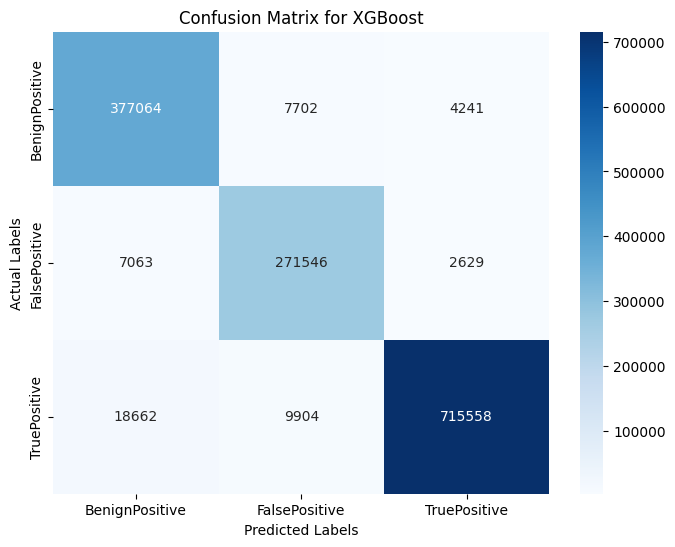

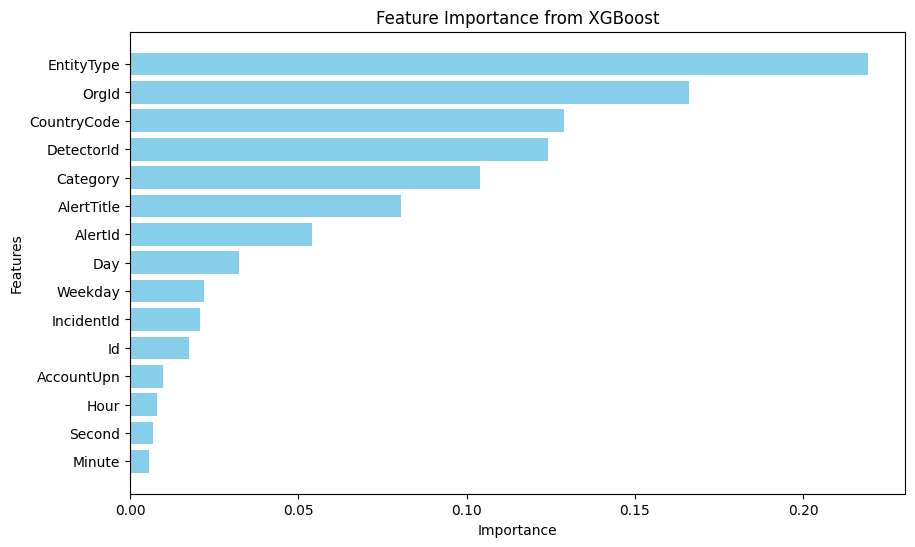

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Full Dataset
# -------------------------------

dftrain = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftrain.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]

# -------------------------------
# Step 3: Label Encode All Features
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder_target.fit_transform(dftrain['IncidentGrade'])

# Encode all features
# Option 1: Use separate LabelEncoders for each feature (recommended if you need to inverse transform)
label_encoders = {}
for col in dftrain.columns:
    if col != 'IncidentGrade':
        le = LabelEncoder()
        dftrain[col] = le.fit_transform(dftrain[col].astype(str))
        label_encoders[col] = le  # Store the encoder if you need to inverse transform later

# -------------------------------
# Step 4: Split Features and Target
# -------------------------------

X = dftrain.drop(columns=['IncidentGrade'])
y = dftrain['IncidentGrade']

# -------------------------------
# Step 5: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 6: Split Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

# Compute sample weights for training data
sample_weights = y_train.map(class_weight_dict)

# -------------------------------
# Step 8: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 9: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the full dataset...")
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# -------------------------------
# Step 10: Evaluate the Model
# -------------------------------

# Predict on validation set
y_pred_xgb = xgb.predict(X_val)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization
# -------------------------------

# Map encoded labels back to original labels
labels = label_encoder_target.classes_

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix_xgb, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# -------------------------------
# Feature Importance Visualization
# -------------------------------

# Get feature importances from the model
feature_importances = xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_feature_names = X.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To show the highest importance feature on top
plt.show()


executing above good prediction code to dftrain and dftest

Training Set Size: 3300193 samples
Validation Set Size: 1414369 samples

Class Weights:
{np.int64(0): np.float64(1.211949045297068), np.int64(1): np.float64(1.676362587197504), np.int64(2): np.float64(0.6335717727645344)}

Training the XGBoost model on the training dataset...

Validation Accuracy: 0.9645
Validation F1 Score (Weighted): 0.9647
Validation Recall (Weighted): 0.9645
Validation Precision (Weighted): 0.9653

Validation Confusion Matrix:
[[377064   7702   4241]
 [  7063 271546   2629]
 [ 18662   9904 715558]]

Validation Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.94      0.97      0.95    389007
 FalsePositive       0.94      0.97      0.95    281238
  TruePositive       0.99      0.96      0.98    744124

      accuracy                           0.96   1414369
     macro avg       0.96      0.97      0.96   1414369
  weighted avg       0.97      0.96      0.96   1414369



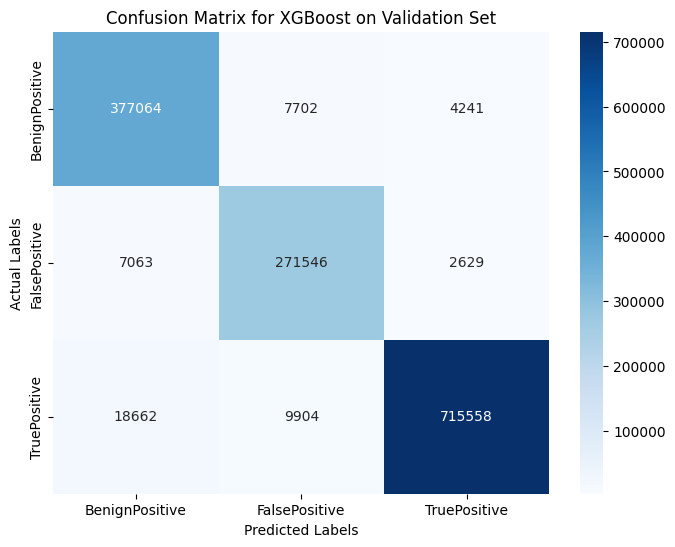

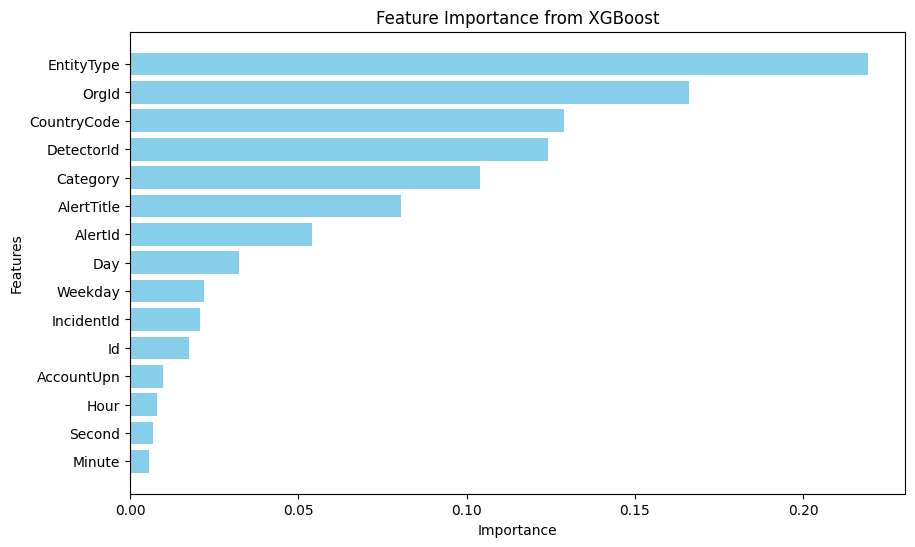

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Training Dataset
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\cleandftrain.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]

# -------------------------------
# Step 3: Label Encode All Features in Training Data
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder_target.fit_transform(dftrain['IncidentGrade'])

# Encode all features in training data
label_encoders = {}
for col in dftrain.columns:
    if col != 'IncidentGrade':
        le = LabelEncoder()
        dftrain[col] = le.fit_transform(dftrain[col].astype(str))
        label_encoders[col] = le  # Store the encoder for future use

# -------------------------------
# Step 4: Split Features and Target in Training Data
# -------------------------------

X_train_full = dftrain.drop(columns=['IncidentGrade'])
y_train_full = dftrain['IncidentGrade']

# -------------------------------
# Step 5: Feature Scaling for Training Data
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_full), columns=X_train_full.columns)

# -------------------------------
# Step 6: Split Training Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

# Compute sample weights for training data
sample_weights = y_train.map(class_weight_dict)

# -------------------------------
# Step 8: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 9: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the training dataset...")
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# -------------------------------
# Step 10: Evaluate the Model on Validation Set
# -------------------------------

# Predict on validation set
y_pred_val = xgb.predict(X_val)

# Calculate performance metrics
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
precision_val = precision_score(y_val, y_pred_val, average='weighted')
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"\nValidation Accuracy: {accuracy_val:.4f}")
print(f"Validation F1 Score (Weighted): {f1_val:.4f}")
print(f"Validation Recall (Weighted): {recall_val:.4f}")
print(f"Validation Precision (Weighted): {precision_val:.4f}")

# Print Confusion Matrix
print("\nValidation Confusion Matrix:")
print(conf_matrix_val)

# Detailed classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization for Validation Set
# -------------------------------

# Map encoded labels back to original labels
labels = label_encoder_target.classes_

# Create a DataFrame for the confusion matrix
conf_matrix_val_df = pd.DataFrame(conf_matrix_val, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost on Validation Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# -------------------------------
# Feature Importance Visualization
# -------------------------------

# Get feature importances from the model
feature_importances = xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_feature_names = X_train.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To show the highest importance feature on top
plt.show()

# -------------------------------
# Step 11: Load the Test Dataset
# -------------------------------

dftest = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 12: Select Important Features in Test Data
# -------------------------------

dftest = dftest[important_features]  # Use the same features as in training

# -------------------------------
# Step 13: Label Encode All Features in Test Data
# -------------------------------

# Encode the target variable 'IncidentGrade' if it exists in test data
if 'IncidentGrade' in dftest.columns:
    dftest['IncidentGrade'] = label_encoder_target.transform(dftest['IncidentGrade'])
else:
    # If 'IncidentGrade' is not in test data, set it to None
    dftest['IncidentGrade'] = None

# Encode all features in test data using the same encoders as training data
for col in dftest.columns:
    if col != 'IncidentGrade':
        if col in label_encoders:
            le = label_encoders[col]
            dftest[col] = dftest[col].astype(str)
            # Handle unseen labels in test data
            dftest[col] = dftest[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
        else:
            print(f"Warning: No label encoder found for column '{col}'.")

# -------------------------------
# Step 14: Handle Unseen Labels in Test Data
# -------------------------------

# Replace any -1 (unseen labels) with a new label
for col in dftest.columns:
    if col != 'IncidentGrade':
        if dftest[col].dtype == np.int32 or dftest[col].dtype == np.int64:
            continue  # Skip numeric columns
        else:
            unseen_label = max(label_encoders[col].classes_.astype(int)) + 1
            dftest[col] = dftest[col].replace(-1, unseen_label)

# -------------------------------
# Step 15: Split Features and Target in Test Data
# -------------------------------

X_test = dftest.drop(columns=['IncidentGrade'])
y_test = dftest['IncidentGrade'] if 'IncidentGrade' in dftest.columns else None

# -------------------------------
# Step 16: Feature Scaling for Test Data
# -------------------------------

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# -------------------------------
# Step 17: Evaluate the Model on Test Set
# -------------------------------

# Predict on test set
y_pred_test = xgb.predict(X_test_scaled)

# If true labels are available, evaluate the model
if y_test is not None and y_test.isnull().sum() == 0:
    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)

    print(f"\nTest Accuracy: {accuracy_test:.4f}")
    print(f"Test F1 Score (Weighted): {f1_test:.4f}")
    print(f"Test Recall (Weighted): {recall_test:.4f}")
    print(f"Test Precision (Weighted): {precision_test:.4f}")

    # Print Confusion Matrix
    print("\nTest Confusion Matrix:")
    print(conf_matrix_test)

    # Detailed classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder_target.classes_))

    # -------------------------------
    # Confusion Matrix Visualization for Test Set
    # -------------------------------

    # Map encoded labels back to original labels
    labels = label_encoder_target.classes_

    # Create a DataFrame for the confusion matrix
    conf_matrix_test_df = pd.DataFrame(conf_matrix_test, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for XGBoost on Test Set')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
else:
    # If 'IncidentGrade' is not available or contains nulls in dftest, output predictions
    print("\nPredictions on Test Set:")
    decoded_predictions = label_encoder_target.inverse_transform(y_pred_test)
    print(decoded_predictions)


using above good prediction code with dftrain and dftest without validation and njob without class weights less acc for false psitive


Training the XGBoost model on the full dataset...

Accuracy: 0.8765
F1 Score (Weighted): 0.8788
Recall (Weighted): 0.8765
Precision (Weighted): 0.8840

Confusion Matrix:
[[ 478220   26780   22209]
 [  34634  326106   35342]
 [  30739  104782 1002522]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.88      0.91      0.89    527209
 FalsePositive       0.71      0.82      0.76    396082
  TruePositive       0.95      0.88      0.91   1138043

      accuracy                           0.88   2061334
     macro avg       0.85      0.87      0.86   2061334
  weighted avg       0.88      0.88      0.88   2061334



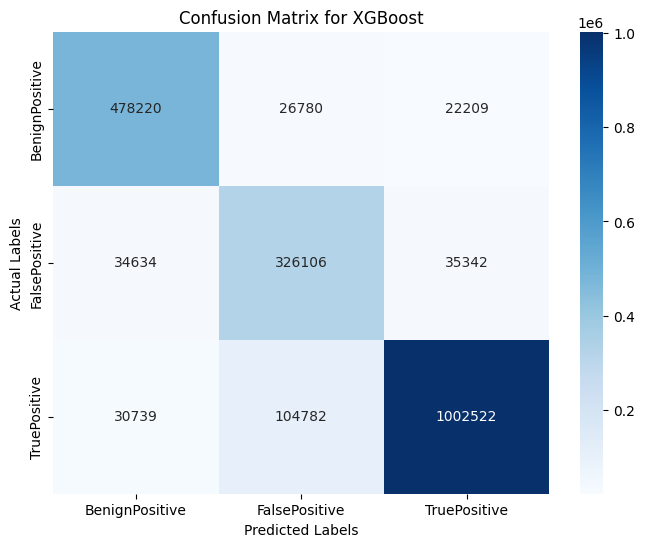

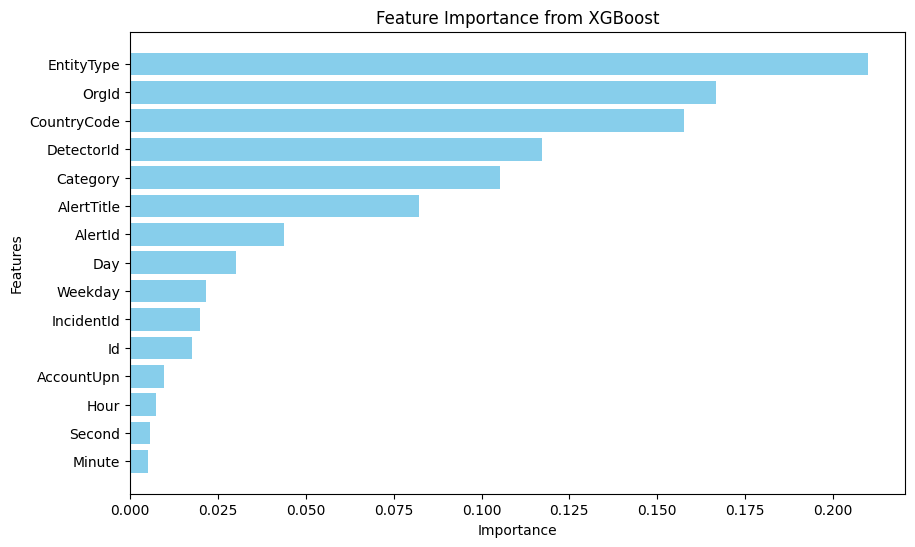

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Datasets
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]
dftest = dftest[important_features]

# -------------------------------
# Step 3: Define Safe Label Transform Function
# -------------------------------

def safe_label_transform(le, series):
    """Transforms labels, assigning 'unknown' to unseen labels."""
    known_classes = set(le.classes_)
    return series.apply(lambda x: x if x in known_classes else 'unknown')

# -------------------------------
# Step 4: Encode All Features with LabelEncoder and Handle Unseen Labels
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder_target.fit_transform(dftrain['IncidentGrade'])
dftest['IncidentGrade'] = label_encoder_target.transform(dftest['IncidentGrade'])

# Encode all features with handling for unseen labels
label_encoders = {}
for col in dftrain.columns:
    if col != 'IncidentGrade':
        le = LabelEncoder()
        # Fit on training data
        le.fit(dftrain[col].astype(str))
        dftrain[col] = le.transform(dftrain[col].astype(str))
        
        # Handle unseen labels in test data
        dftest[col] = safe_label_transform(le, dftest[col].astype(str))
        
        # Update classes to include 'unknown'
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        
        # Transform test data, assigning 'unknown' to unseen labels
        dftest[col] = le.transform(dftest[col].astype(str))
        
        label_encoders[col] = le  # Store the encoder

# -------------------------------
# Step 5: Split Features and Target
# -------------------------------

X_train = dftrain.drop(columns=['IncidentGrade'])
y_train = dftrain['IncidentGrade']

X_test = dftest.drop(columns=['IncidentGrade'])
y_test = dftest['IncidentGrade']

# -------------------------------
# Step 6: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# -------------------------------
# Step 7: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': 4  # Use 4 CPU cores
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 8: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the full dataset...")
xgb.fit(X_train_scaled, y_train)

# -------------------------------
# Step 9: Evaluate the Model on Test Set
# -------------------------------

# Predict on test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization
# -------------------------------

# Get the unique labels from the predictions and actual values
labels = label_encoder_target.classes_.tolist()

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix_xgb, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# -------------------------------
# Feature Importance Visualization
# -------------------------------

# Get feature importances from the model
feature_importances = xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_feature_names = X_train.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To show the highest importance feature on top
plt.show()


XGB WITH ABOVE ERROR SOLVING AND CLASS WEIGHTS TO IMPROVE FALSE POSITIVE


Training the XGBoost model on the full dataset with class weights...

Accuracy: 0.8579
F1 Score (Weighted): 0.8608
Recall (Weighted): 0.8579
Precision (Weighted): 0.8702

Confusion Matrix:
[[487903  27307  11999]
 [ 40395 318216  37471]
 [ 54408 121388 962247]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.84      0.93      0.88    527209
 FalsePositive       0.68      0.80      0.74    396082
  TruePositive       0.95      0.85      0.90   1138043

      accuracy                           0.86   2061334
     macro avg       0.82      0.86      0.84   2061334
  weighted avg       0.87      0.86      0.86   2061334



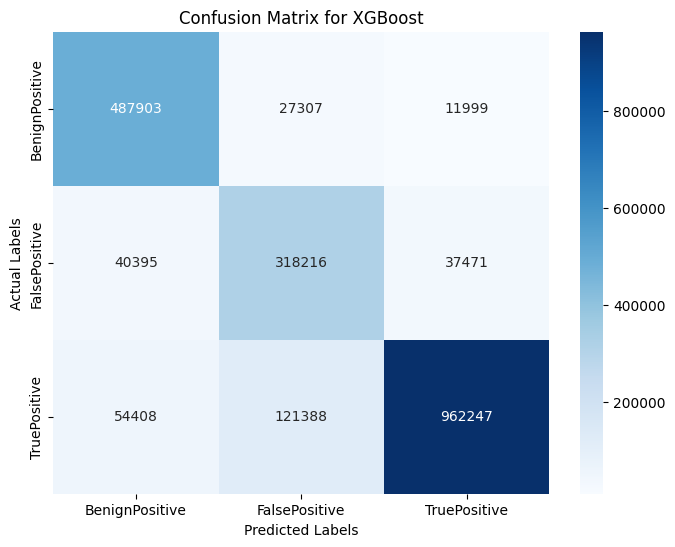

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Datasets
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]
dftest = dftest[important_features]

# -------------------------------
# Step 3: Define Safe Label Transform Function
# -------------------------------

def safe_label_transform(le, series):
    """Transforms labels, assigning 'unknown' to unseen labels."""
    known_classes = set(le.classes_)
    return series.apply(lambda x: x if x in known_classes else 'unknown')

# -------------------------------
# Step 4: Encode All Features with LabelEncoder and Handle Unseen Labels
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder_target.fit_transform(dftrain['IncidentGrade'])
dftest['IncidentGrade'] = label_encoder_target.transform(dftest['IncidentGrade'])

# Encode all features with handling for unseen labels
label_encoders = {}
for col in dftrain.columns:
    if col != 'IncidentGrade':
        le = LabelEncoder()
        # Fit on training data
        le.fit(dftrain[col].astype(str))
        dftrain[col] = le.transform(dftrain[col].astype(str))
        
        # Handle unseen labels in test data
        dftest[col] = safe_label_transform(le, dftest[col].astype(str))
        
        # Update classes to include 'unknown'
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        
        # Transform test data, assigning 'unknown' to unseen labels
        dftest[col] = le.transform(dftest[col].astype(str))
        
        label_encoders[col] = le  # Store the encoder

# -------------------------------
# Step 5: Split Features and Target
# -------------------------------

X_train = dftrain.drop(columns=['IncidentGrade'])
y_train = dftrain['IncidentGrade']

X_test = dftest.drop(columns=['IncidentGrade'])
y_test = dftest['IncidentGrade']

# -------------------------------
# Step 6: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights based on the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Assign sample weights
y_train_series = pd.Series(y_train)
sample_weights = y_train_series.map(class_weight_dict)

# -------------------------------
# Step 8: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': 4  # Use 4 CPU cores
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 9: Train the Model with Class Weights
# -------------------------------

print("\nTraining the XGBoost model on the full dataset with class weights...")
xgb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# -------------------------------
# Step 10: Evaluate the Model on Test Set
# -------------------------------

# Predict on test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization
# -------------------------------

# Get original class labels (DO NOT include 'unknown')
labels = label_encoder_target.classes_.tolist()  # No 'unknown'

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix_xgb, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


XGB WITH LABEL ENCODER, SMOTE AND CLASS WEIGHTS TOGETHER AND VALIDATION INCLUDED

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Datasets
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Define Safe Label Transform Function
# -------------------------------

def safe_label_transform(le, series):
    """Transforms labels, assigning 'unknown' to unseen labels."""
    known_classes = set(le.classes_)
    return series.apply(lambda x: x if x in known_classes else 'unknown')

# -------------------------------
# Step 3: Encode All Features with LabelEncoder and Handle Unseen Labels
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
dftrain['IncidentGrade'] = label_encoder_target.fit_transform(dftrain['IncidentGrade'])
dftest['IncidentGrade'] = label_encoder_target.transform(dftest['IncidentGrade'])

# Encode all features with handling for unseen labels
label_encoders = {}
for col in dftrain.columns:
    if col != 'IncidentGrade':
        le = LabelEncoder()
        # Fit on training data
        le.fit(dftrain[col].astype(str))
        dftrain[col] = le.transform(dftrain[col].astype(str))
        
        # Handle unseen labels in test data
        dftest[col] = safe_label_transform(le, dftest[col].astype(str))
        
        # Update classes to include 'unknown'
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        
        # Transform test data, assigning 'unknown' to unseen labels
        dftest[col] = le.transform(dftest[col].astype(str))
        
        label_encoders[col] = le  # Store the encoder

# -------------------------------
# Step 4: Split Features and Target
# -------------------------------

X_train = dftrain.drop(columns=['IncidentGrade'])
y_train = dftrain['IncidentGrade']

X_test = dftest.drop(columns=['IncidentGrade'])
y_test = dftest['IncidentGrade']

# -------------------------------
# Step 5: Apply SMOTE to Balance the Dataset
# -------------------------------

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# -------------------------------
# Step 6: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# -------------------------------
# Step 7: Compute Class Weights and Print Them
# -------------------------------

# Compute class weights based on the resampled training data
classes = np.unique(y_train_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_resampled)
class_weight_dict = dict(zip(classes, class_weights))

# Print class weights assigned to each class
print("\nClass Weights Assigned for Each Class:")
for cls, weight in class_weight_dict.items():
    print(f"Class {cls}: {weight:.4f}")

# Assign sample weights
y_train_resampled_series = pd.Series(y_train_resampled)
sample_weights = y_train_resampled_series.map(class_weight_dict)

# -------------------------------
# Step 8: Split Training Data into Training and Validation Sets
# -------------------------------

X_train_final, X_val, y_train_final, y_val, sample_weights_train, sample_weights_val = train_test_split(
    X_train_scaled, y_train_resampled, sample_weights, test_size=0.2, random_state=42, stratify=y_train_resampled)

# -------------------------------
# Step 9: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': 4  # Use 4 CPU cores
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 10: Train the Model with Class Weights and Validation Set
# -------------------------------

print("\nTraining the XGBoost model on SMOTE-resampled data with class weights and validation set...")
xgb.fit(X_train_final, y_train_final, sample_weight=sample_weights_train, 
        eval_set=[(X_val, y_val)], early_stopping_rounds=50, eval_metric="mlogloss", verbose=True)

# -------------------------------
# Step 11: Evaluate the Model on the Validation Set
# -------------------------------

# Predict on validation set
y_pred_val = xgb.predict(X_val)

# Calculate performance metrics for validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
precision_val = precision_score(y_val, y_pred_val, average='weighted')
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"\nValidation Set Accuracy: {accuracy_val:.4f}")
print(f"Validation Set F1 Score (Weighted): {f1_val:.4f}")
print(f"Validation Set Recall (Weighted): {recall_val:.4f}")
print(f"Validation Set Precision (Weighted): {precision_val:.4f}")

# Print Confusion Matrix for validation set
print("\nConfusion Matrix for Validation Set:")
print(conf_matrix_val)

# Detailed classification report for validation set
print("\nClassification Report for Validation Set:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder_target.classes_))

# -------------------------------
# Step 12: Evaluate the Model on the Original Test Set
# -------------------------------

# Predict on test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Calculate performance metrics for test set
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"\nTest Set Accuracy: {accuracy_xgb:.4f}")
print(f"Test Set F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Test Set Recall (Weighted): {recall_xgb:.4f}")
print(f"Test Set Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix for test set
print("\nConfusion Matrix for Test Set:")
print(conf_matrix_xgb)

# Detailed classification report for test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization for Validation and Test Sets
# -------------------------------

# Get original class labels
labels = label_encoder_target.classes_.tolist()

# Confusion matrix for validation set
conf_matrix_val_df = pd.DataFrame(conf_matrix_val, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Confusion matrix for test set
conf_matrix_xgb_df = pd.DataFrame(conf_matrix_xgb, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


: 

using xgb with ordinal encoding ,label_encoder and class_weights


Training the XGBoost model on the full dataset...

Accuracy: 0.8071
F1 Score (Weighted): 0.8101
Recall (Weighted): 0.8071
Precision (Weighted): 0.8249

Confusion Matrix:
[[ 365287   97583   64339]
 [  13123  289762   93197]
 [  17930  111441 1008672]]

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.92      0.69      0.79    527209
 FalsePositive       0.58      0.73      0.65    396082
  TruePositive       0.86      0.89      0.88   1138043

      accuracy                           0.81   2061334
     macro avg       0.79      0.77      0.77   2061334
  weighted avg       0.82      0.81      0.81   2061334



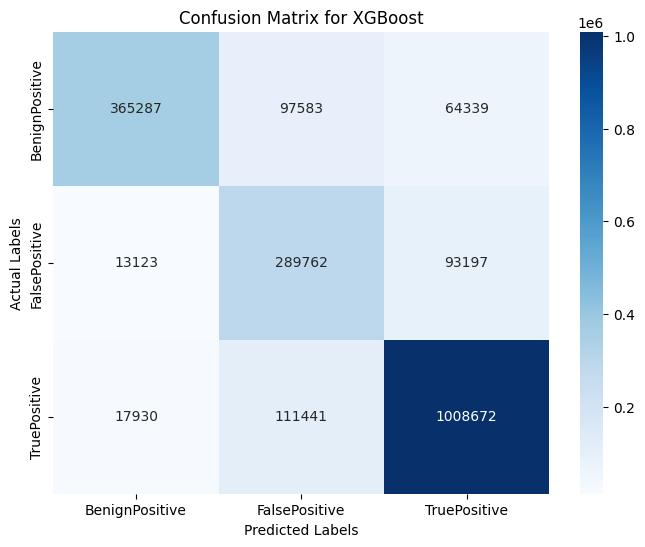

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Datasets
# -------------------------------

dftrain = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'F:\guvi projects\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]
dftest = dftest[important_features]

# -------------------------------
# Step 3: Encode All Features with OrdinalEncoder
# -------------------------------

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Define feature columns (exclude target)
feature_cols = [col for col in dftrain.columns if col != 'IncidentGrade']

# Separate features and target
X_train = dftrain[feature_cols]
y_train = dftrain['IncidentGrade']

X_test = dftest[feature_cols]
y_test = dftest['IncidentGrade']

# Fit the encoder on training data
ordinal_encoder.fit(X_train)

# Transform both training and test data
X_train_encoded = ordinal_encoder.transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_encoded, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_encoded, columns=feature_cols)

# -------------------------------
# Step 4: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=feature_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns=feature_cols)

# -------------------------------
# Step 5: Encode Target Variable
# -------------------------------

# Create a LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Encode the target variable 'IncidentGrade'
y_train_encoded = label_encoder_target.fit_transform(y_train)
y_test_encoded = label_encoder_target.transform(y_test)

# -------------------------------
# Step 6: Compute Class Weights
# -------------------------------

# Compute class weights based on the training data
classes = np.unique(y_train_encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)
class_weight_dict = dict(zip(classes, class_weights))

# Assign sample weights
# Convert y_train_encoded to a Pandas Series for mapping
y_train_series = pd.Series(y_train_encoded)
sample_weights = y_train_series.map(class_weight_dict)

# -------------------------------
# Step 7: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': 4  # Use 4 CPU cores
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 8: Train the Model with Sample Weights
# -------------------------------

print("\nTraining the XGBoost model on the full dataset...")
xgb.fit(X_train_scaled, y_train_encoded, sample_weight=sample_weights)

# -------------------------------
# Step 9: Evaluate the Model on Test Set
# -------------------------------

# Predict on test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Calculate performance metrics
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)

print(f"\nAccuracy: {accuracy_xgb:.4f}")
print(f"F1 Score (Weighted): {f1_xgb:.4f}")
print(f"Recall (Weighted): {recall_xgb:.4f}")
print(f"Precision (Weighted): {precision_xgb:.4f}")

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix_xgb)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder_target.classes_))

# -------------------------------
# Step 10: Confusion Matrix Visualization
# -------------------------------

# Get original class labels
labels = label_encoder_target.classes_.tolist()

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix_xgb, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


using above good performance code for oridinal encoding

Training data shape: (4714562, 41)
Test data shape: (2061334, 41)
Training Set Size: 3300193 samples
Validation Set Size: 1414369 samples

Class Weights:
{np.int64(0): np.float64(1.211949045297068), np.int64(1): np.float64(1.676362587197504), np.int64(2): np.float64(0.6335717727645344)}

Training the XGBoost model on the training dataset...

Validation Accuracy: 0.9038
Validation F1 Score (Weighted): 0.9055
Validation Recall (Weighted): 0.9038
Validation Precision (Weighted): 0.9137

Validation Confusion Matrix:
[[367043  18902   3062]
 [ 24594 254541   2103]
 [ 60057  27402 656665]]

Validation Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.81      0.94      0.87    389007
 FalsePositive       0.85      0.91      0.87    281238
  TruePositive       0.99      0.88      0.93    744124

      accuracy                           0.90   1414369
     macro avg       0.88      0.91      0.89   1414369
  weighted avg       0.91      0.90 

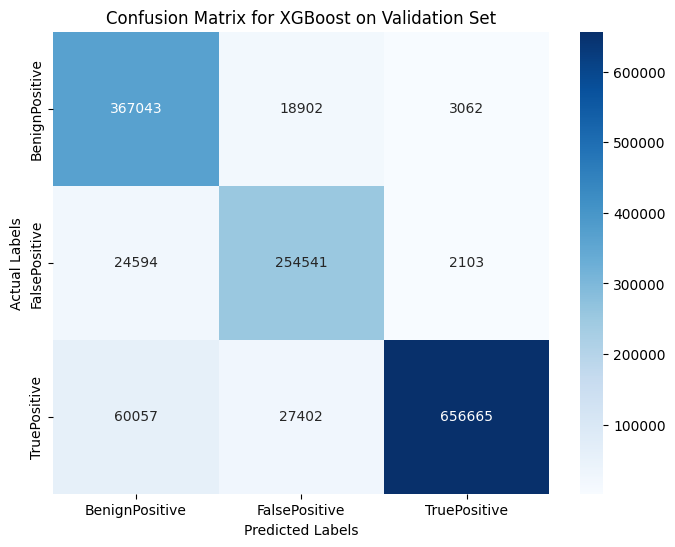

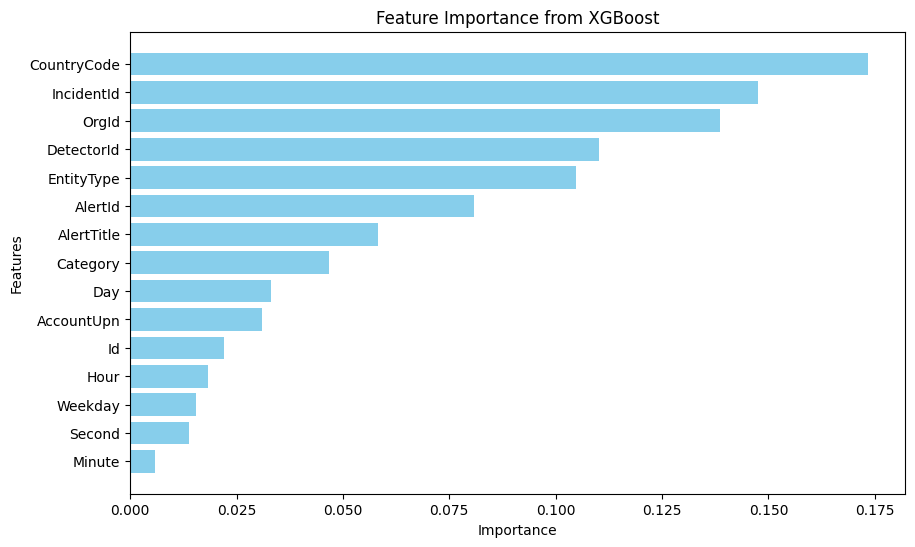


Test Accuracy: 0.6966
Test F1 Score (Weighted): 0.6938
Test Recall (Weighted): 0.6966
Test Precision (Weighted): 0.7373

Test Confusion Matrix:
[[219435 152415 155359]
 [ 16383 288759  90940]
 [ 29132 181077 927834]]

Test Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.83      0.42      0.55    527209
 FalsePositive       0.46      0.73      0.57    396082
  TruePositive       0.79      0.82      0.80   1138043

      accuracy                           0.70   2061334
     macro avg       0.69      0.65      0.64   2061334
  weighted avg       0.74      0.70      0.69   2061334



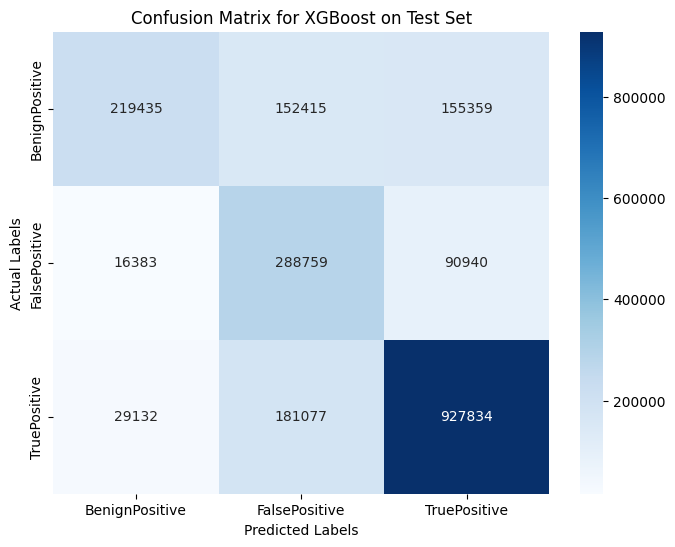

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Datasets
# -------------------------------

dftrain = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftest.csv')

# Optional: Sample data for testing
# dftrain = dftrain.sample(n=100000, random_state=42)
# dftest = dftest.sample(n=100000, random_state=42)

print(f"Training data shape: {dftrain.shape}")
print(f"Test data shape: {dftest.shape}")

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable
]

dftrain = dftrain[important_features]
dftest = dftest[important_features]

# -------------------------------
# Step 3: Separate Features and Target
# -------------------------------

X_train_full = dftrain.drop(columns=['IncidentGrade'])
y_train_full = dftrain['IncidentGrade']

X_test = dftest.drop(columns=['IncidentGrade'])
y_test = dftest['IncidentGrade'] if 'IncidentGrade' in dftest.columns else None

# -------------------------------
# Step 4: Encode Features Using OrdinalEncoder
# -------------------------------

from sklearn.preprocessing import OrdinalEncoder

# Create OrdinalEncoder with handle_unknown parameter
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training data features
ordinal_encoder.fit(X_train_full)

# Transform training and test data features
X_train_encoded = ordinal_encoder.transform(X_train_full)
X_test_encoded = ordinal_encoder.transform(X_test)

# Convert to DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_train_full.columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_test.columns)

# -------------------------------
# Step 5: Encode Target Variable
# -------------------------------

from sklearn.preprocessing import LabelEncoder

label_encoder_target = LabelEncoder()
y_train_encoded = label_encoder_target.fit_transform(y_train_full)

if y_test is not None and y_test.isnull().sum() == 0:
    y_test_encoded = label_encoder_target.transform(y_test)
else:
    y_test_encoded = None

# -------------------------------
# Step 6: Feature Scaling
# -------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns)

# -------------------------------
# Step 7: Split Training Data into Train and Validation Sets
# -------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.3, random_state=42, stratify=y_train_encoded
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 8: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass Weights:")
print(class_weight_dict)

# Compute sample weights for training data
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# -------------------------------
# Step 9: Define XGBoost Model with Optimized Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,          # Reduced depth
    'n_estimators': 100,     # Reduced number of trees
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': -1             # Utilize all available cores
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 10: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the training dataset...")
xgb.fit(X_train, y_train, sample_weight=sample_weights, verbose=True)

# -------------------------------
# Step 11: Evaluate the Model on Validation Set
# -------------------------------

# Predict on validation set
y_pred_val = xgb.predict(X_val)

# Calculate performance metrics
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
precision_val = precision_score(y_val, y_pred_val, average='weighted')
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"\nValidation Accuracy: {accuracy_val:.4f}")
print(f"Validation F1 Score (Weighted): {f1_val:.4f}")
print(f"Validation Recall (Weighted): {recall_val:.4f}")
print(f"Validation Precision (Weighted): {precision_val:.4f}")

# Print Confusion Matrix
print("\nValidation Confusion Matrix:")
print(conf_matrix_val)

# Detailed classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder_target.classes_))

# -------------------------------
# Confusion Matrix Visualization for Validation Set
# -------------------------------

# Map encoded labels back to original labels
labels = label_encoder_target.classes_

# Create a DataFrame for the confusion matrix
conf_matrix_val_df = pd.DataFrame(conf_matrix_val, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost on Validation Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# -------------------------------
# Feature Importance Visualization
# -------------------------------

# Get feature importances from the model
feature_importances = xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_feature_names = X_train.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To show the highest importance feature on top
plt.show()

# -------------------------------
# Step 12: Evaluate the Model on Test Set
# -------------------------------

# Predict on test set
y_pred_test = xgb.predict(X_test_scaled)

# If true labels are available, evaluate the model
if y_test_encoded is not None:
    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test_encoded, y_pred_test)
    f1_test = f1_score(y_test_encoded, y_pred_test, average='weighted')
    recall_test = recall_score(y_test_encoded, y_pred_test, average='weighted')
    precision_test = precision_score(y_test_encoded, y_pred_test, average='weighted')
    conf_matrix_test = confusion_matrix(y_test_encoded, y_pred_test)

    print(f"\nTest Accuracy: {accuracy_test:.4f}")
    print(f"Test F1 Score (Weighted): {f1_test:.4f}")
    print(f"Test Recall (Weighted): {recall_test:.4f}")
    print(f"Test Precision (Weighted): {precision_test:.4f}")

    # Print Confusion Matrix
    print("\nTest Confusion Matrix:")
    print(conf_matrix_test)

    # Detailed classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder_target.classes_))

    # -------------------------------
    # Confusion Matrix Visualization for Test Set
    # -------------------------------

    # Create a DataFrame for the confusion matrix
    conf_matrix_test_df = pd.DataFrame(conf_matrix_test, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for XGBoost on Test Set')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
else:
    # If 'IncidentGrade' is not available or contains nulls in dftest, output predictions
    print("\nPredictions on Test Set:")
    decoded_predictions = label_encoder_target.inverse_transform(y_pred_test)
    print(decoded_predictions)


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Training and Testing Datasets
# -------------------------------

# Replace 'path_to_dftrain.csv' and 'path_to_dftest.csv' with your actual file paths
dftrain = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable if present in dftest
]

dftrain = dftrain[important_features]

# Check if 'IncidentGrade' is present in dftest
if 'IncidentGrade' in dftest.columns:
    dftest = dftest[important_features]
    y_test_present = True
else:
    important_features_no_target = [col for col in important_features if col != 'IncidentGrade']
    dftest = dftest[important_features_no_target]
    y_test_present = False

# -------------------------------
# Step 3: Encode All Features with OrdinalEncoder
# -------------------------------

# Define categorical columns (all features except 'IncidentGrade')
categorical_cols = [col for col in dftrain.columns if col != 'IncidentGrade']

# Initialize OrdinalEncoder with handling unknown categories
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit encoder on dftrain
ordinal_encoder.fit(dftrain[categorical_cols])

# Transform dftrain
X_train = ordinal_encoder.transform(dftrain[categorical_cols])
X_train = pd.DataFrame(X_train, columns=categorical_cols)

# Encode 'IncidentGrade' in dftrain using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(dftrain['IncidentGrade'])

# -------------------------------
# Step 4: Process dftest
# -------------------------------

# Transform dftest using the same encoder
X_test = ordinal_encoder.transform(dftest[categorical_cols])
X_test = pd.DataFrame(X_test, columns=categorical_cols)

# If 'IncidentGrade' is in dftest, encode it
if y_test_present:
    y_test = label_encoder.transform(dftest['IncidentGrade'])

# -------------------------------
# Step 5: Feature Scaling
# -------------------------------

scaler = StandardScaler()

# Fit scaler on X_train and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Step 6: Compute Class Weights
# -------------------------------

# Compute class weights for handling class imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Map class weights to sample weights
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# -------------------------------
# Step 7: Define XGBoost Model with Best Hyperparameters
# -------------------------------

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgb = XGBClassifier(**best_params)

# -------------------------------
# Step 8: Train the Model
# -------------------------------

print("\nTraining the XGBoost model on the full dataset...")
xgb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# -------------------------------
# Step 9: Predict on dftest
# -------------------------------

y_pred_test = xgb.predict(X_test_scaled)

# -------------------------------
# Step 10: Evaluate the Model
# -------------------------------

if y_test_present:
    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    
    print(f"\nTest Set Performance:")
    print(f"Accuracy: {accuracy_test:.4f}")
    print(f"F1 Score (Weighted): {f1_test:.4f}")
    print(f"Recall (Weighted): {recall_test:.4f}")
    print(f"Precision (Weighted): {precision_test:.4f}")
    
    print("\nConfusion Matrix:")
    print(conf_matrix_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
else:
    # If 'IncidentGrade' is not available in dftest, output predictions
    print("\nPredictions on Test Set:")
    print(y_pred_test)



Training the XGBoost model on the full dataset...

Test Set Performance:
Accuracy: 0.8071
F1 Score (Weighted): 0.8101
Recall (Weighted): 0.8071
Precision (Weighted): 0.8249

Confusion Matrix:
[[ 365287   97583   64339]
 [  13123  289762   93197]
 [  17930  111441 1008672]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79    527209
           1       0.58      0.73      0.65    396082
           2       0.86      0.89      0.88   1138043

    accuracy                           0.81   2061334
   macro avg       0.79      0.77      0.77   2061334
weighted avg       0.82      0.81      0.81   2061334



XGB WITH GOOD PREDICTION dftrain and aftest ,ORDINAL ENCODER,CLASS WEIGHT

Training Set Size: 3771649 samples
Validation Set Size: 942913 samples

Training the XGBoost model...

Test Set Performance:
Accuracy: 0.8631
F1 Score (Weighted): 0.8659
Recall (Weighted): 0.8631
Precision (Weighted): 0.8769

Classification Report on Test Set:
                precision    recall  f1-score   support

BenignPositive       0.77      0.92      0.84    527209
 FalsePositive       0.75      0.82      0.79    396082
  TruePositive       0.97      0.85      0.91   1138043

      accuracy                           0.86   2061334
     macro avg       0.83      0.86      0.84   2061334
  weighted avg       0.88      0.86      0.87   2061334



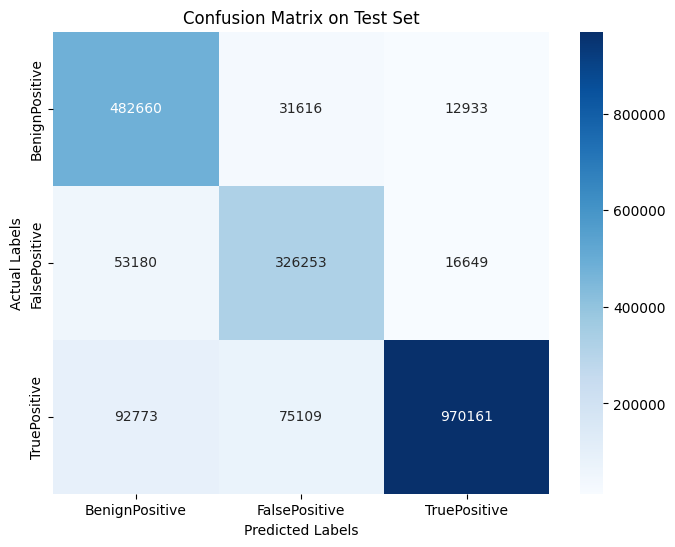

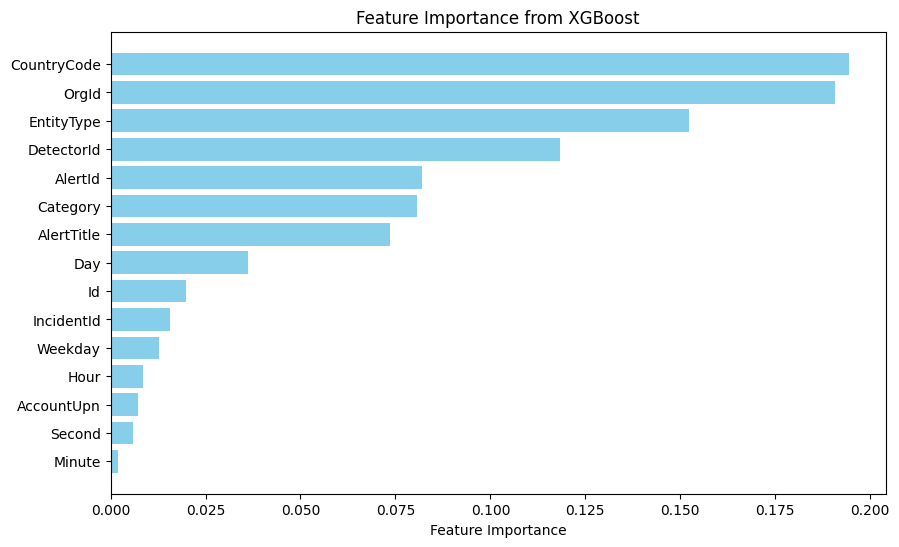

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: Load the Training and Testing Datasets
# -------------------------------

# Replace with your actual file paths
dftrain = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftrain.csv')
dftest = pd.read_csv(r'C:\CYBERSECURITY\virtualenv\finaldftest.csv')

# -------------------------------
# Step 2: Select Important Features
# -------------------------------

important_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'Day', 'EntityType', 'Hour',
    'Second', 'Minute', 'Weekday', 'AccountUpn', 'CountryCode',
    'IncidentGrade'  # Include target variable if present in dftest
]

dftrain = dftrain[important_features]

# Check if 'IncidentGrade' is present in dftest
y_test_present = 'IncidentGrade' in dftest.columns

if y_test_present:
    dftest = dftest[important_features]
else:
    important_features_no_target = [col for col in important_features if col != 'IncidentGrade']
    dftest = dftest[important_features_no_target]

# -------------------------------
# Step 3: Encode Features Appropriately
# -------------------------------

# Features to Label Encode (Nominal Categorical)
label_encode_features = [
    'OrgId', 'DetectorId', 'AlertTitle', 'AlertId', 'Category',
    'IncidentId', 'Id', 'EntityType', 'AccountUpn', 'CountryCode'
]

# Features to Ordinal Encode (Ordinal Categorical)
ordinal_encode_features = ['Weekday']

# Features to Leave as Numeric (Continuous)
numeric_features = ['Day', 'Hour', 'Minute', 'Second']

# Initialize encoders
label_encoders = {}
ordinal_encoders = {}

# Label Encode Nominal Categorical Features
for col in label_encode_features:
    le = LabelEncoder()
    # Fit on combined data to include all possible categories
    combined_data = pd.concat([dftrain[col], dftest[col]], axis=0).astype(str)
    le.fit(combined_data)
    dftrain[col] = le.transform(dftrain[col].astype(str))
    dftest[col] = le.transform(dftest[col].astype(str))
    label_encoders[col] = le

# Ordinal Encode Ordinal Categorical Features
for col in ordinal_encode_features:
    oe = OrdinalEncoder()
    # Fit on combined data to include all possible categories
    combined_data = pd.concat([dftrain[[col]], dftest[[col]]], axis=0)
    oe.fit(combined_data)
    dftrain[col] = oe.transform(dftrain[[col]])
    dftest[col] = oe.transform(dftest[[col]])
    ordinal_encoders[col] = oe

# No encoding needed for numeric features

# -------------------------------
# Step 4: Encode the Target Variable 'IncidentGrade'
# -------------------------------

# Initialize LabelEncoder for the target variable
label_encoder_target = LabelEncoder()

# Fit on combined target data to ensure consistent encoding
combined_target = pd.concat([dftrain['IncidentGrade'], dftest['IncidentGrade']], axis=0)
label_encoder_target.fit(combined_target)

# Transform the target variable in both dftrain and dftest
dftrain['IncidentGrade'] = label_encoder_target.transform(dftrain['IncidentGrade'])
if y_test_present:
    dftest['IncidentGrade'] = label_encoder_target.transform(dftest['IncidentGrade'])

# -------------------------------
# Step 5: Split dftrain into Training and Validation Sets
# -------------------------------

# Separate features and target variable
X = dftrain.drop(columns=['IncidentGrade'])
y = dftrain['IncidentGrade']

# Perform train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Validation Set Size: {X_val.shape[0]} samples")

# -------------------------------
# Step 6: Feature Scaling
# -------------------------------

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on X_train numeric features and transform
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = dftest.drop(columns=['IncidentGrade'], errors='ignore').copy()

# Apply scaling to numeric features
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

# -------------------------------
# Step 7: Compute Class Weights
# -------------------------------

# Compute class weights using the training data
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Map class weights to sample weights for training data
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# -------------------------------
# Step 8: Define XGBoost Model with Adjusted Hyperparameters
# -------------------------------

# Adjusted hyperparameters (you can modify these as needed)
adjusted_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,          # Reduced depth to prevent overfitting
    'n_estimators': 100,     # Reduced number of trees for faster training
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'subsample': 1.0,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgb = XGBClassifier(**adjusted_params)

# -------------------------------
# Step 9: Train the Model (Removed early_stopping_rounds)
# -------------------------------

print("\nTraining the XGBoost model...")

xgb.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights,
    verbose=True
)

# -------------------------------
# Step 10: Predict on dftest
# -------------------------------

y_pred_test = xgb.predict(X_test_scaled)

# -------------------------------
# Step 11: Evaluate the Model
# -------------------------------

if y_test_present:
    y_test = dftest['IncidentGrade']
    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)

    print(f"\nTest Set Performance:")
    print(f"Accuracy: {accuracy_test:.4f}")
    print(f"F1 Score (Weighted): {f1_test:.4f}")
    print(f"Recall (Weighted): {recall_test:.4f}")
    print(f"Precision (Weighted): {precision_test:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder_target.classes_))

    # -------------------------------
    # Step 12: Visualize the Confusion Matrix
    # -------------------------------

    # Map encoded labels back to original labels
    labels = label_encoder_target.classes_

    # Create a DataFrame for the confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix_test, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on Test Set')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
else:
    # If 'IncidentGrade' is not available in dftest, output predictions
    print("\nPredictions on Test Set:")
    print(y_pred_test)

# -------------------------------
# Step 13: Feature Importance Visualization
# -------------------------------

# Get feature importance from the model
importance = xgb.feature_importances_
features = X_train_scaled.columns

# Sort feature importance in descending order
sorted_idx = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_idx]
sorted_features = features[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()
